# Model-guided design of regulatory elements

In this example, we use gReLU to perform model-guided design of accessible DNA elements for microglial cells.

In [1]:
import anndata
import numpy as np
import pandas as pd
import os
import importlib
import re

%matplotlib inline

## Load the pre-trained Catlas model from the model zoo

This is a binary classification model trained on snATAC-seq data from Catlas (http://catlas.org/humanenhancer/).

In [2]:
import grelu.resources
model = grelu.resources.load_model(project='human-atac-catlas', model_name="model")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: avantikalal (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact model:latest, 825.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.2


## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [78]:
for key in list(model.data_params.keys())[:21]:
    if key !="tasks":
        print(key, model.data_params[key])

train_bin_size 1
train_chroms ['chr18', 'chr5', 'chr1', 'chr17', 'chr9', 'chr19', 'chr8', 'chr21', 'chr14', 'chr20', 'chr22', 'chr10', 'chr15', 'chr12', 'chr16', 'chr3', 'chr4', 'chr11', 'chr2', 'chr6']
train_end both
train_genome hg38
train_label_aggfunc None
train_label_len 200
train_label_transform_func None
train_max_label_clip None
train_max_pair_shift 0
train_max_seq_shift 1
train_min_label_clip None
train_n_alleles 1
train_n_augmented 1
train_n_seqs 1022128
train_n_tasks 204
train_padded_label_len 200
train_padded_seq_len 202
train_predict False
train_rc True
train_seq_len 200


Note the parameter `train_seq_len`. This tells us that the model was trained on 200 bp long sequences.

`model.data_params['tasks']` is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe called tasks:

In [12]:
tasks = pd.DataFrame(model.data_params["tasks"])
tasks.head()

,name,cell type
0,Follicular,Follicular
1,Fibro General,Fibro General
2,Acinar,Acinar
3,T Lymphocyte 1 (CD8+),T Lymphocyte 1 (CD8+)
4,T lymphocyte 2 (CD4+),T lymphocyte 2 (CD4+)


## Example 1: Starting from a random sequence, evolve a sequence with high accessibility in microglia using directed evolution.

### Generate a random starting sequence

In [13]:
import grelu.sequence.utils
start_seq = grelu.sequence.utils.generate_random_sequences(
    n=1, # number of sequences to generate
    seq_len=model.data_params['train_seq_len'], # Length of the generated sequence
    seed=0,
    output_format="strings"
)[0]
start_seq

'ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGTGTAGAAACCGAACTACGGTACCTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCACCCTATCGACGAGACTGGCATCCTAGGTGTTTGCGGTGTTGGTACGTGCGCAGGTATGTAAGAGTGGTAAACGA'

### Create the objective to optimize - predictions in microglia

In the first example, we want to create a sequence that has a high probability of accessibility in microglia (regardless of what it does in other cell types). We first must define the objective that we want to optimize. Such objective functions are defined in `grelu.transforms.prediction_transforms`. We pick the `Aggregate` class, which tells the model to aggregate predictions over a subset of output tasks or positions.

In [14]:
from grelu.transforms.prediction_transforms import Aggregate

microglia_score = Aggregate(
    tasks = ["Microglia"],
    model = model,
)

### Run directed evolution to maximize the prediction in microglia, ignoring other cell types

`grelu.design` contains algorithms for model-guided sequence design. We pick the `evolve` function, which performs directed evolution. Note that it selects the sequence with the highest objective function value at every iteration, which in this case is the highest predicted accessibility in microglia. If you wanted to instead select the sequence with the lowest prediction in microglia, you could add `weight=-1` to the `Aggregate` object.

In [15]:
import grelu.design

output = grelu.design.evolve(
    [start_seq], # The initial sequences
    model, 
    prediction_transform=microglia_score, # Objective to optimize 
    max_iter=5, # Number of iterations for directed evolution
    num_workers=8,
    devices=0,
    return_seqs="all", # Return all the evolved sequences
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Iteration 0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: 0.193
Iteration 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.75it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 0.449
Iteration 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 0.654
Iteration 3
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: 0.896
Iteration 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.85it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: 0.976
Iteration 5
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 5: 0.991
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 45.98it/s]


### Examine the output

The output of `grelu.design.evolve` is a dataframe which contains all the sequences generated during directed evolution, and the model's predictions. It also contains the position that was mutated and the base that was substituted at that position.

In [16]:
output.head()

,iter,start_seq,best_in_iter,prediction_score,seq_score,total_score,seq,position,allele,Microglia
0,0,0,True,0.193436,0,0.193436,ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,NaN,NaN,0.193184
1,1,0,False,0.172949,0,0.172949,CTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,C,0.172949
2,1,0,False,0.176766,0,0.176766,GTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,G,0.176766
3,1,0,False,0.185231,0,0.185231,TTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,T,0.185231
4,1,0,False,0.180554,0,0.180554,AACATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,1.0,A,0.180554


We can visualize the model's predictions on the sequences generated at each iteration:

/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2392: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


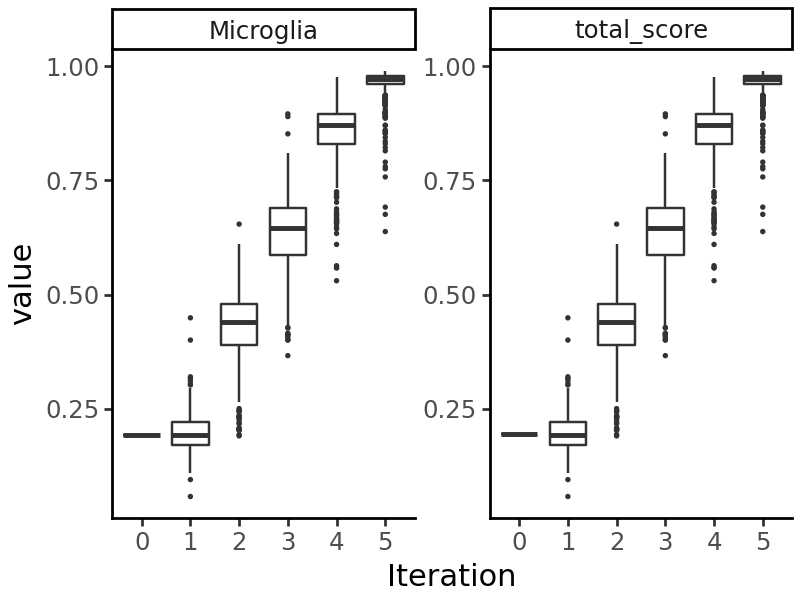

In [17]:
import grelu.visualize
grelu.visualize.plot_evolution(output, outlier_size=.1)

We see that the predicted probability of accessibility in Microglia increases at each iteration.

### Compare the initial and final sequence

Let us take the best sequence from the final iteration (iteration 5):

In [18]:
end_seq = output[output.iter==5].sort_values('total_score').iloc[-1].seq
end_seq

'ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGGGTAGAAACCGAACTACGGTACTTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCGCCCTCTCGACGAGACTGGCATCCTAGGTGTTTGCGGTGTTGGTACGTGCGCAGTTATGTAAGAGTGGTAAACGA'

We can compare this to the sequence we started with to see what changes were made:

In [19]:
import grelu.sequence.mutate
mutated_positions = grelu.sequence.mutate.seq_differences(start_seq, end_seq, verbose=True)

Position: 62 Reference base: T Alternate base: G Reference sequence: GATTGTGTAG
Position: 84 Reference base: C Alternate base: T Reference sequence: GGTACCTCCT
Position: 125 Reference base: A Alternate base: G Reference sequence: TTCCCACCCT
Position: 130 Reference base: A Alternate base: C Reference sequence: ACCCTATCGA
Position: 179 Reference base: G Alternate base: T Reference sequence: CGCAGGTATG


Next, we will use the `grelu.interpret` module to understand why these changes were made. One way to do this is by calculating per-base importance scores for the start and end sequence. gReLU provides several methods to do this, including In Silico Mutagenesis (ISM), DeepShap, InputxGradient and Integrated Gradients. Let's first try Deepshap on the start and end sequences.

In [20]:
import grelu.interpret.score

start_attrs = grelu.interpret.score.get_attributions(
    model, start_seq, prediction_transform=microglia_score, device=0,
    method="deepshap", seed=0,
)
end_attrs = grelu.interpret.score.get_attributions(
    model, end_seq, prediction_transform=microglia_score, device=0,
    method="deepshap", seed=0,
)

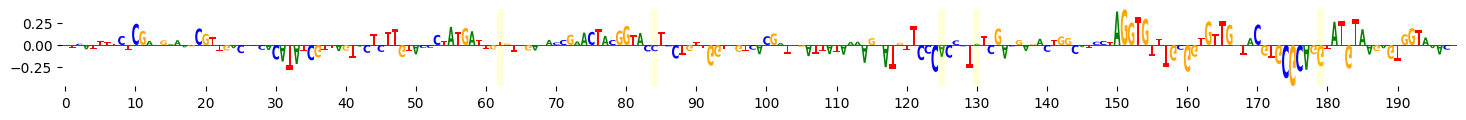

In [21]:
grelu.visualize.plot_attributions(
    start_attrs, 
    highlight_positions=mutated_positions, # Highlight the mutated positions
    ticks=10,
    figsize=(18, 1)
)

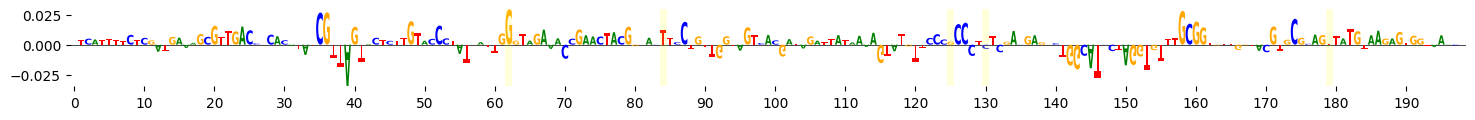

In [23]:
grelu.visualize.plot_attributions(
    end_attrs,
    highlight_positions=mutated_positions, # Highlight the mutated positions,
    ticks=10,
    figsize=(18, 1),
)

We see that several of the mutated bases are in regions of negative attributions, i.e. which reduce the model's predictions.

## Example 2: Use sequence constraints

gReLU's evolution function allows you to impose additional constraints upon the evolutionary process. For example, we can try to promote or avoid instances of a specific pattern or motif in our designed sequences. In this example, we suppose that we want to avoid occurrences of the sequence pattern `CG` or its reverse complement `GC`. 

Let us count how many times this pattern occurs in our initial and final sequences.

In [24]:
unwanted_seqs = ["CG", "GC"]

n_initial = np.sum([len(re.findall(x, start_seq)) for x in unwanted_seqs])
n_final = np.sum([len(re.findall(x, end_seq)) for x in unwanted_seqs])

n_initial, n_final

(17, 19)

### Create additional design objective: A sequence transform

We see that although directed evolution improved the predicted accessibility of the sequence in microglia, it also increased the number of unwanted sequence patterns. So, we want to add a penalty for these patterns in our evolutionary process. We accomplish this by creating another transform, this time one that operates on the sequence instead of the model's predictions. These transforms are found in the `grelu.transforms.seq_transforms` module.

Here, we use the `PatternScore` class, which counts the number of times given subsequences occur in a sequence, and assigns the sequence a score based on this count. If you want to instead count the number of matches of a motif, use the `MotifScore` class.

In [25]:
from grelu.transforms.seq_transforms import PatternScore

We create an instance of this class that counts the occurrences of the unwanted subsequences and assigns a score of -0.1 for each occurrence. The negative sign means that sequences containing these subsequences will be penalized during evolution.

In [26]:
gc_penalizer = PatternScore(
    patterns = unwanted_seqs, # Patterns to count
    weights=[-.1, -.1], # Score to assign to each occurrence of each pattern
)

### Run directed evolution including the sequence penalty

In [27]:
output = grelu.design.evolve(
    [start_seq], # The initial sequences
    model, 
    prediction_transform=microglia_score, # Prediction objective to optimize 
    seq_transform=gc_penalizer, # Sequence objective to optimize
    max_iter=5, # Number of iterations for directed evolution
    num_workers=8,
    devices=0,
    return_seqs="all", # Return all the evolved sequences
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.49it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: -1.507
Iteration 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.49it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: -1.251
Iteration 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: -1.046
Iteration 3
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.33it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: -0.810
Iteration 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.08it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: -0.638
Iteration 5
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 75.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 5: -0.501
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 48.46it/s]


### Examine results

Let's examine the new optimized sequence and see whether it has fewer instances of `GC` and `CG`.

In [28]:
end_seq = output[output.iter==5].sort_values('total_score').iloc[-1].seq
np.sum([len(re.findall(x, end_seq)) for x in unwanted_seqs])

14

We see that the number of GC/CG occurrences has been reduced. When we visualize the output of evolution, we see that both the prediction objective (accessibility in microglia) and the sequence objective have been optimized: 

/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2392: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


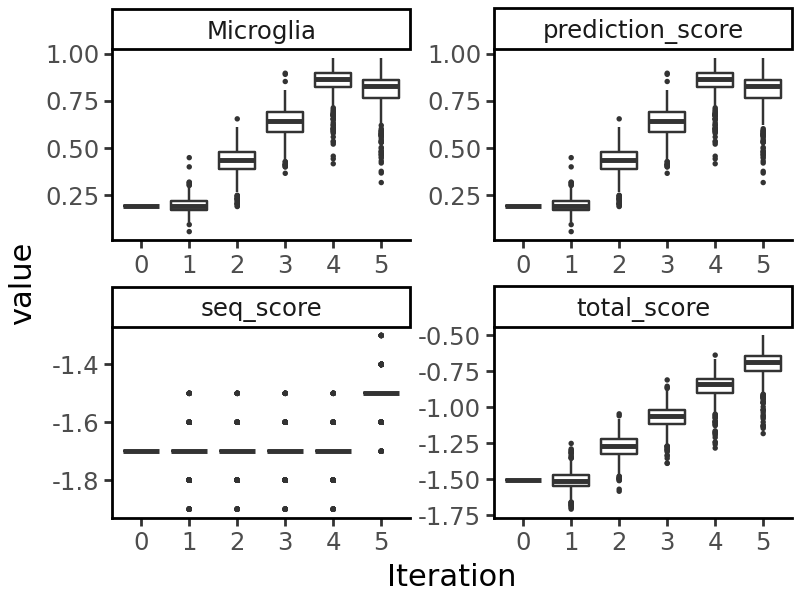

In [29]:
grelu.visualize.plot_evolution(output, outlier_size=.1)

## Example 3: Evolve a real genomic sequence toward microglia-specific accessibility using directed evolution

In this example, we want to evolve a sequence that has a high predicted probability of being accessible in microglia, but low predicted probability of accessibility in other cell types (e.g. neurons). To increase the realism of the final sequence, we also want to start with a set of real genomic sequences instead of random sequences. These should be sequences that were not seen by the model during training or validation.

We can examine the model's `data_params` to see which chromosomes were used for training and validation:

### Select genomic starting sequences

In [30]:
import grelu.data.utils

chromosomes_seen_by_model = model.data_params["train_chroms"] + model.data_params["val_chroms"]
all_autosomes = grelu.data.utils.get_chromosomes("autosomes")
set(all_autosomes).difference(chromosomes_seen_by_model)

{'chr13'}

We find that chromosome 13 was not seen by the model during training. We can now generate some random regions from this chromosome:

In [31]:
from grelu.io.genome import read_sizes
sizes = read_sizes(genome="hg38")
chr_size = sizes.loc[sizes.chrom=="chr13", "size"].values[0]
chr_size

114364328

In [53]:
rng = np.random.RandomState(0)

starts = rng.randint(low=1000000, high=chr_size-1000000, size=10)
start_intervals = pd.DataFrame({
    "chrom":"chr11",
    "start": starts,
    "end": starts + model.data_params["train_seq_len"],
})

start_intervals

,chrom,start,end
0,chr11,76434668,76434868
1,chr11,3215104,3215304
2,chr11,39712131,39712331
3,chr11,61969723,61969923
4,chr11,59554051,59554251
5,chr11,16039847,16040047
6,chr11,75753033,75753233
7,chr11,90739541,90739741
8,chr11,41294130,41294330
9,chr11,1374564,1374764


### Define design objective: cell type-specific accessibility in microglia

We now want to optimize a more complicated objective. We want to create sequences that have a high probability of accessibility in microglia but low probability of accessibility in neurons. We begin by identifying neuron-related cell types in the model's output:

In [34]:
neuron_tasks = tasks.name[tasks.name.str.contains("Neuron")]
print(neuron_tasks)

51                 Enteric Neuron
109     Fetal Excitatory Neuron 3
110     Fetal Excitatory Neuron 4
111     Fetal Excitatory Neuron 5
112     Fetal Excitatory Neuron 6
113     Fetal Excitatory Neuron 7
114     Fetal Excitatory Neuron 8
125          Fetal Adrenal Neuron
145          Fetal Retinal Neuron
146          Fetal Enteric Neuron
148        Fetal Placental Neuron
164     Fetal Inhibitory Neuron 1
165     Fetal Inhibitory Neuron 2
166     Fetal Excitatory Neuron 9
167    Fetal Excitatory Neuron 10
202     Fetal Excitatory Neuron 1
203     Fetal Excitatory Neuron 2
Name: name, dtype: object


We now define our objective using the `Specificity` class of transforms. This class takes the model's predictions and calculates a score by comparing predictions in defined on-target tasks (in this case Microglia) and off-target tasks (in this case, neurons). We can also specify a relative weight for the off-target tasks, how to aggregate the on- and off-target predictions, and soft thresholds for off-target expression.

In [35]:
from grelu.transforms.prediction_transforms import Specificity

mcg_specificity = Specificity(
    on_tasks = "Microglia", # We want high predictions in these
    off_tasks = neuron_tasks, # We want low predictions in these
    on_aggfunc = "mean", 
    off_aggfunc = "max", # Compare the on-target prediction to the highest prediction in any off-target task.
    model=model,
    compare_func="subtract", # Each sequence will get a score which is the ratio of the on-target and off-target scores
)

### Run directed evolution

Note that here, we start with multiple sequences and set `for_each=False`. This means that the model will evaluate all the starting sequences, choose the best one (with highest microglia-specific predicted accessibility) and continue with that sequence. If we set `for_each=True` instead, we would run directed evolution independently on each starting sequence. That option can be used to generate a more diverse set of evolved sequences.

In [54]:
output = grelu.design.evolve(
    start_intervals, # Start from the natural sequences
    model, 
    genome="hg38",
    prediction_transform=mcg_specificity, # Optimize the specific accessibility score
    max_iter=5,
    num_workers=8,
    devices=0,
    return_seqs="all",
    for_each=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: 0.094
Iteration 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 0.284
Iteration 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 0.436
Iteration 3
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.34it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: 0.549
Iteration 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: 0.677
Iteration 5
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 5: 0.744
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 47.97it/s]


### Visualize the output

We can plot the accessibility of the sequences at each iteration:

/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2392: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


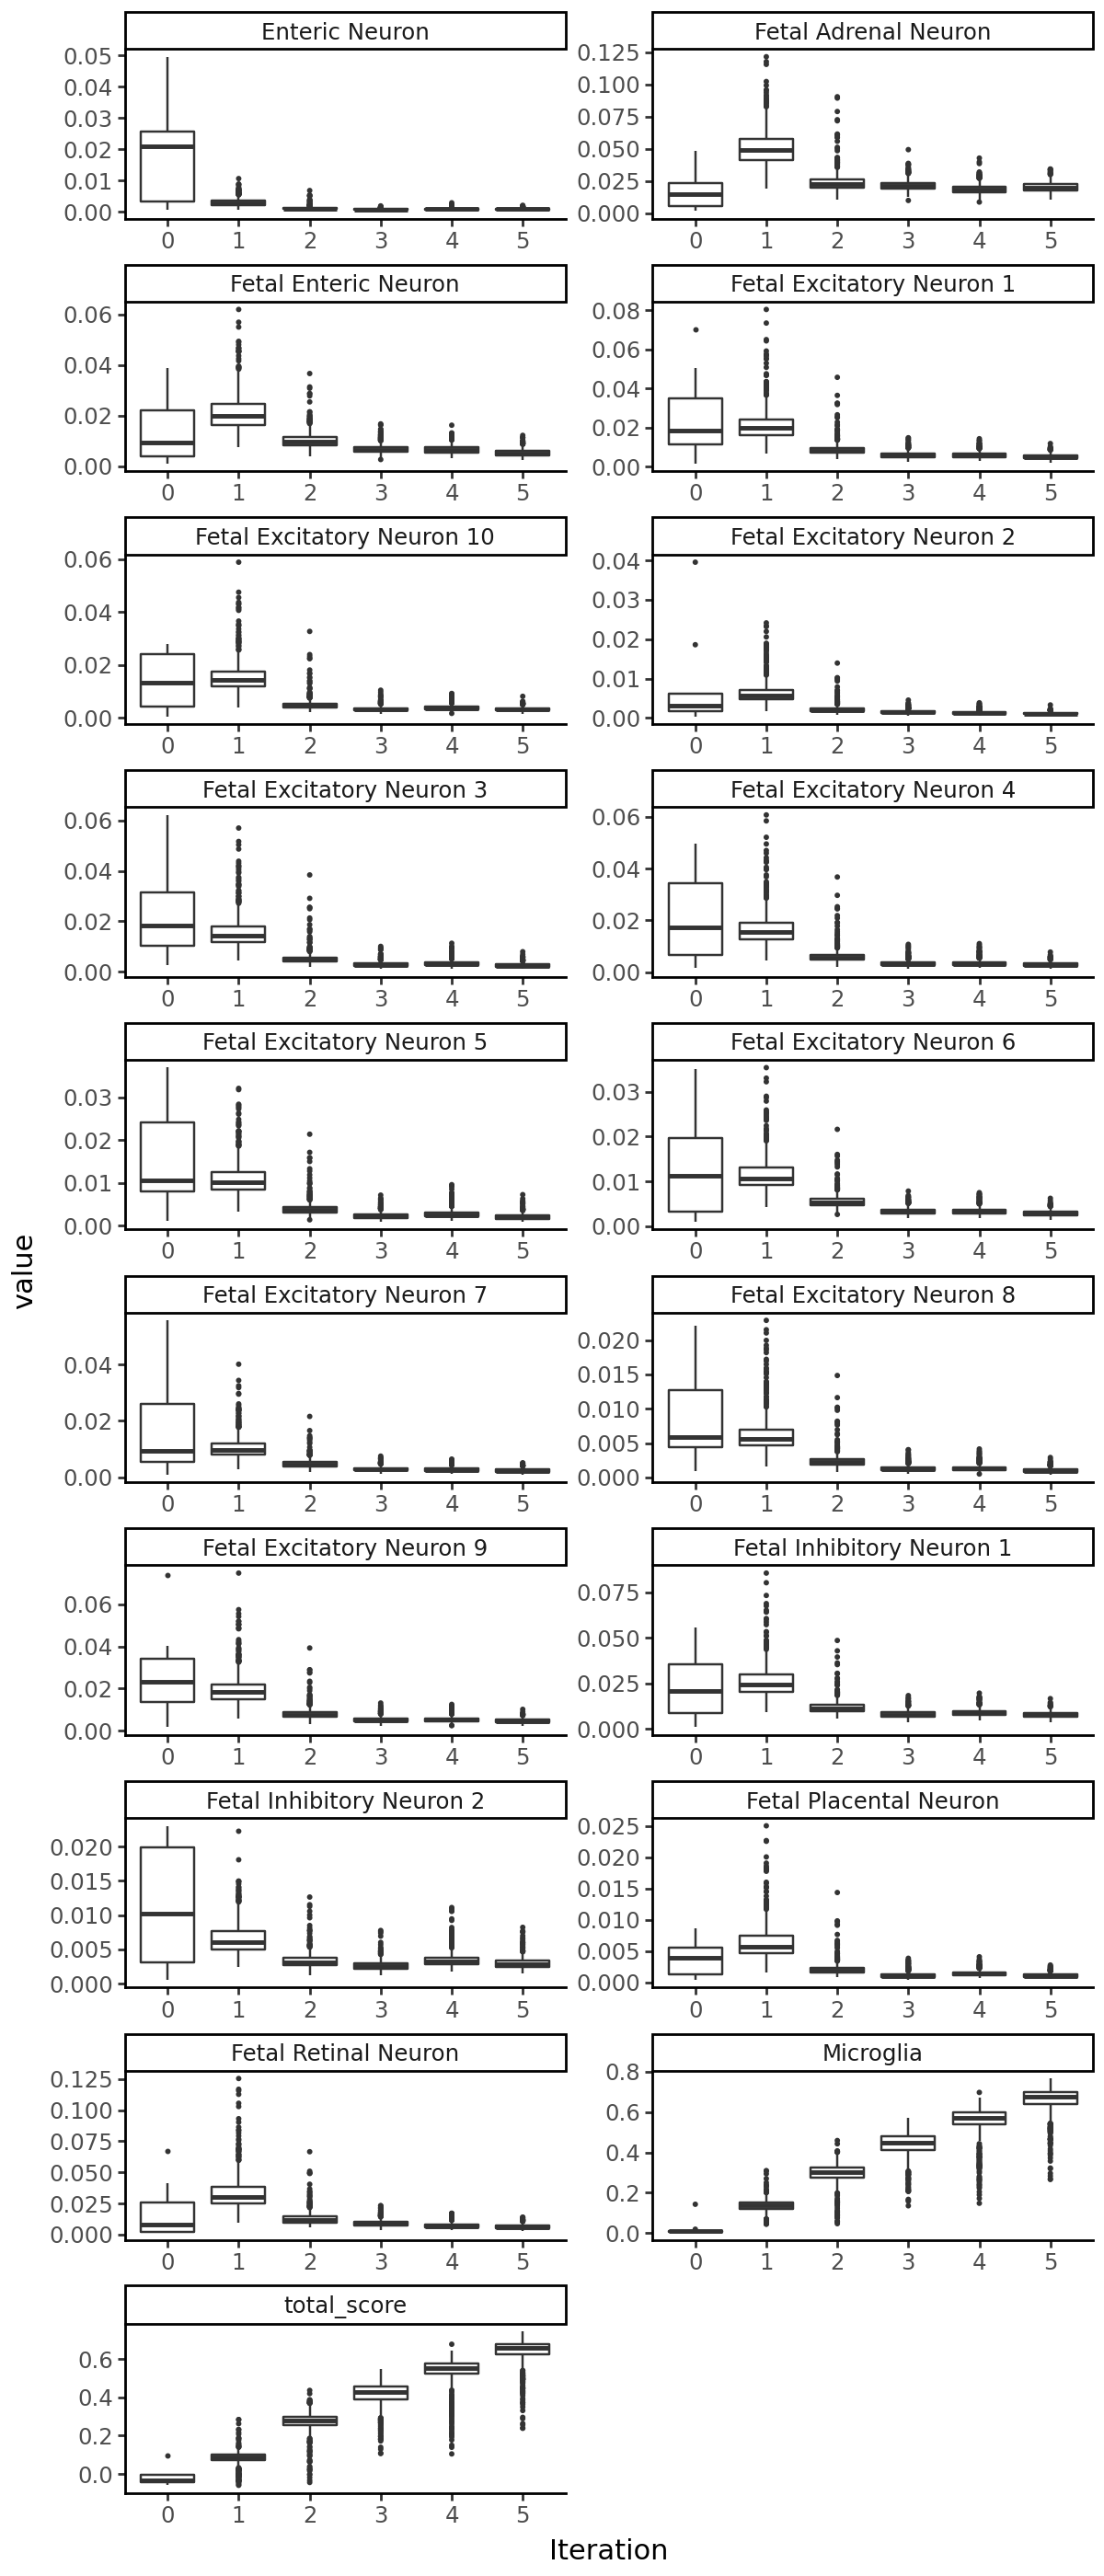

In [55]:
grelu.visualize.plot_evolution(output, figsize=(6, 14), outlier_size=0.2)

### Compare start and end sequences

In [56]:
start_seq = output[output.iter==0].sort_values('total_score').iloc[-1].seq
end_seq = output[output.iter==5].sort_values('total_score').iloc[-1].seq

mutated_positions = grelu.sequence.mutate.seq_differences(start_seq, end_seq, verbose=True)

Position: 68 Reference base: G Alternate base: A Reference sequence: GCGGAGGTTG
Position: 111 Reference base: C Alternate base: A Reference sequence: CTGGGCGACA
Position: 149 Reference base: A Alternate base: G Reference sequence: AAAGAAGAAG
Position: 160 Reference base: A Alternate base: G Reference sequence: AAAAAAAGAA
Position: 170 Reference base: G Alternate base: A Reference sequence: GTGGAGGTTC


This time, let's use Integrated Gradients to visualize the importance of these bases that were mutated at each iteration of evolution. Note also that we supply `prediction_transform=mcg_specificity`, so that we calculate the importance of each base to the specificity of accessibility in microglia.

In [57]:
start_attrs = grelu.interpret.score.get_attributions(
    model, start_seq, prediction_transform=mcg_specificity, device=0, method="integratedgradients",
)
end_attrs = grelu.interpret.score.get_attributions(
    model, end_seq, prediction_transform=mcg_specificity, device=0, method="integratedgradients",
)

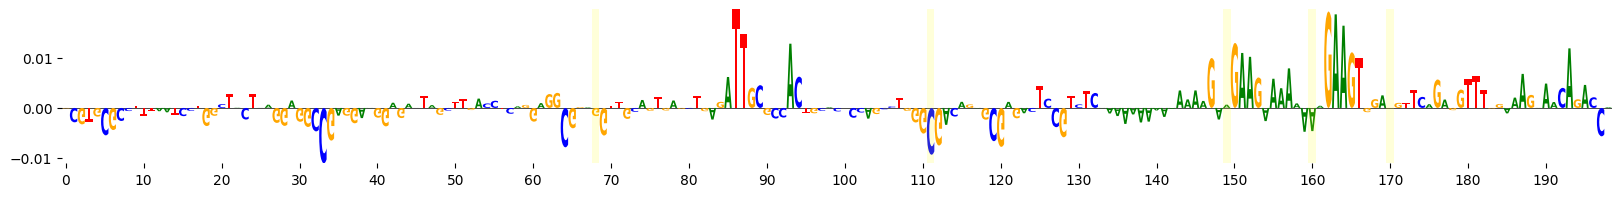

In [58]:
grelu.visualize.plot_attributions(start_attrs, highlight_positions=mutated_positions)

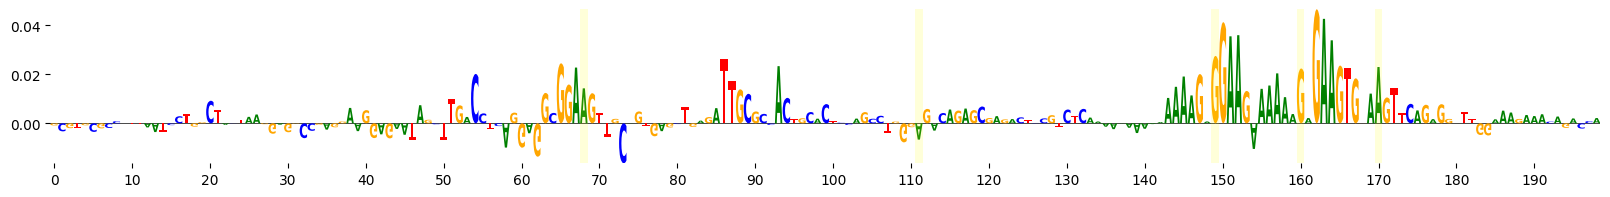

In [59]:
grelu.visualize.plot_attributions(end_attrs, highlight_positions=mutated_positions)

It seems that the evolution process has created new motifs. We can identify the specific motifs that were altered by scanning the reference and alternate sequence with consensus JASPAR motifs and comparing the output.

In [64]:
import grelu.interpret.motifs

comparison = grelu.interpret.motifs.compare_motifs(
    ref_seq = start_seq,
    alt_seq = end_seq,
    motifs="consensus",
    pthresh=5e-4,
    rc=True, # Scan both strands of the sequence
)

Read 637 motifs from file.


In [65]:
comparison[comparison.motif=="AC0622:ELF_SPIB:Ets"].sort_values("start")

sequence,motif,start,end,strand,alt,ref,foldChange
201,AC0622:ELF_SPIB:Ets,33,42,+,9.398374,9.398374,1.0
394,AC0622:ELF_SPIB:Ets,62,71,+,12.853659,0.000000,inf
393,AC0622:ELF_SPIB:Ets,146,155,+,10.869919,0.000000,inf
390,AC0622:ELF_SPIB:Ets,164,173,+,9.341463,0.000000,inf


The `ref` column contains the score for the motif in the original sequence and the `alt` column contains the score in the end sequence. We see that the evolution process has created new instances of the `AC0622:ELF_SPIB:Ets` motif, while leaving the already existing instance unchanged.

## Example 4: Evolution by motif scanning

So far, we have been performing directed evolution by in silico mutagenesis: at each iteration, we create all possible single-base substitutions and choose the best one. Another approach is to insert a given motif into every possible position in the starting sequence, and choose the best one. We can run this approach by choosing `method="pattern"` in `grelu.design.evolve`.

Let's start by getting the sequence of the `AC0622:ELF_SPIB:Ets` motif.

In [66]:
import grelu.io.meme

motifs, _ = grelu.io.meme.read_meme_file("consensus", names=["AC0622:ELF_SPIB:Ets"])
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)

print(patterns)

Read 1 motifs from file.
['AAGAGGAAGT']


### Run evolution

We will now try to run the evolution function for microglia-specific accessibility, this time by scanning the starting sequence with the motif and finding the best position to substitute in this motif. You can do this with multiple motifs with different weights or penalties.

In addition, we demonstrate another constraint in the `grelu.design.evolve` function; you can constrain which positions can be altered, whether by ISM or by motif substitution. Here, we will specify that the motif should only be substituted in the first 100 bases of the sequence.

In [67]:
output = grelu.design.evolve(
    start_intervals, # Start from the natural sequences
    model, 
    genome="hg38",
    prediction_transform=mcg_specificity, # Optimize the specific accessibility score
    max_iter=2, # Since we are modifying a whole motif, we only run 2 iterations
    method="pattern", # Evolution by pattern substitution
    patterns=patterns, # SPIB motif
    num_workers=8,
    devices=0,
    return_seqs="all",
    for_each=False,
    positions=range(100), # Positions allowed for substitution
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: 0.094
Iteration 1
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  0.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 0.743
Iteration 2
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.90it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 0.920
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2392: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


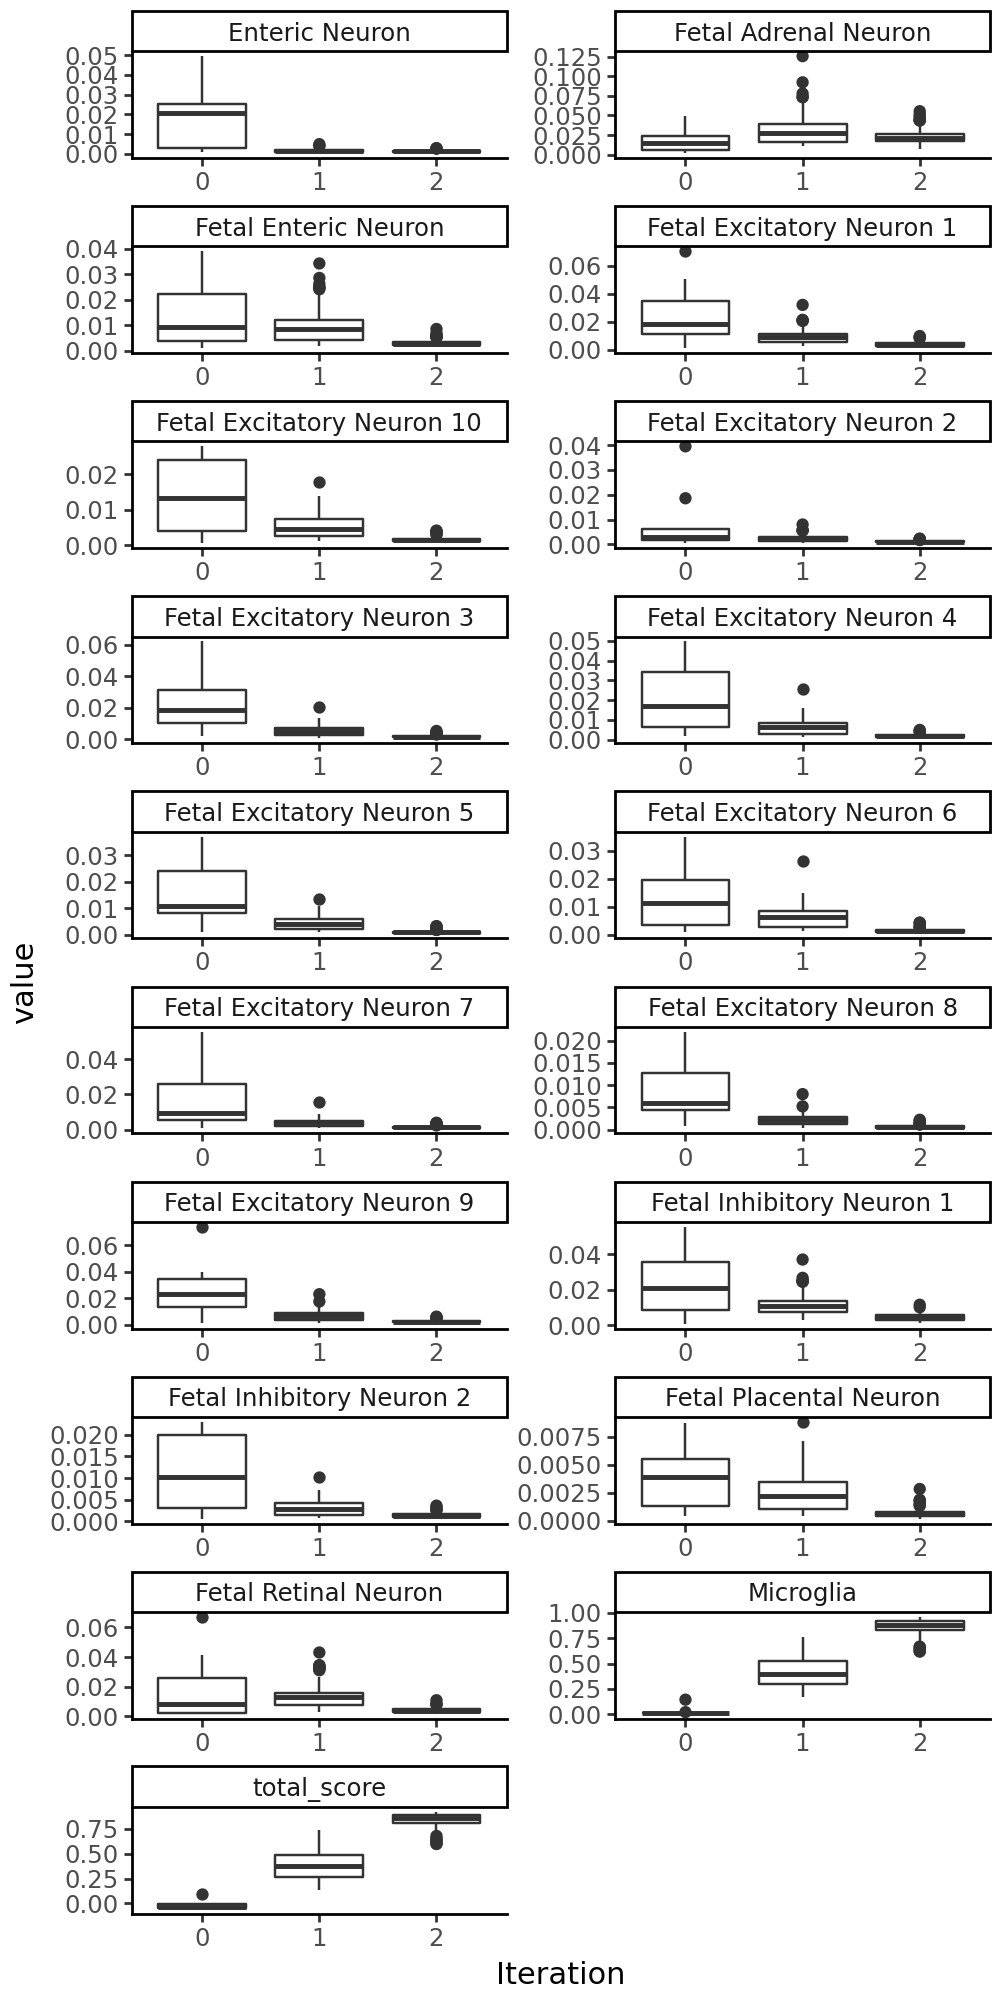

In [68]:
grelu.visualize.plot_evolution(output, figsize=(5,10))

Let's see where the motifs were inserted:

In [69]:
end_seq = output[output.iter==2].sort_values('total_score').iloc[-1].seq
end_attrs = grelu.interpret.score.get_attributions(
    model, end_seq, prediction_transform=mcg_specificity, device=0, method="integratedgradients",
)

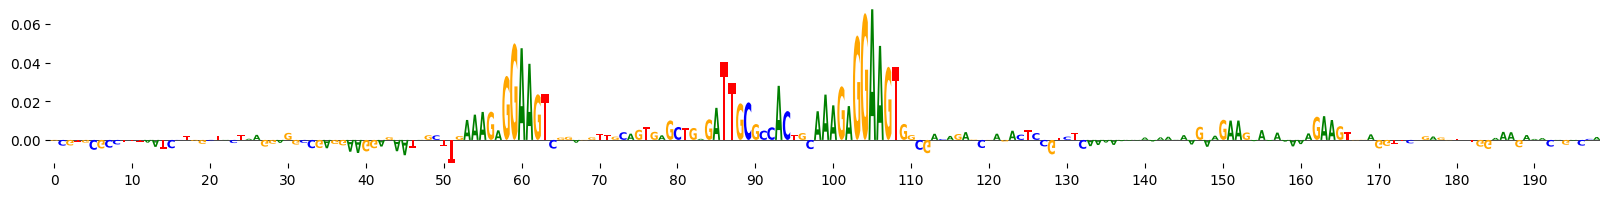

In [70]:
grelu.visualize.plot_attributions(end_attrs)

## Example 5: Ledidi

We also offer the Ledidi method by Schreiber et al. (2020) (https://www.biorxiv.org/content/10.1101/2020.05.21.109686v1). This is a gradient-based approach for sequence optimization. Here, we run Ledidi for the same objective as in example 3.

Ledidi requires a single starting sequence.

In [71]:
start_seq

'GCGTGCGCCTTTAATCCTGGCTACTAAGGAGGCCGAGGAAGGAGAATAGCTTGACCTCAGGAGGCGGAGGTTGCAGTGAGCTGAGATTGCGCCACTGCACTCCAGCCTGGGCGACAGAGCGAGACTCCGTCTCAAAAAAAAAAAAAAGAAGAAGAAAAAAAAGAAGTGGAGGTTCAGAGGTTTGGAAAGAAACAGACCAA'

In [75]:
output = grelu.design.ledidi(
    start_seq,
    model,
    prediction_transform=mcg_specificity,
    max_iter=2000,
    devices=0,
    lr=5e-3,
)

iter=I	input_loss= 0.0	output_loss=-0.0943	total_loss=-9.43	time=0.0195
iter=100	input_loss=0.1562	output_loss=-0.09181	total_loss=-9.025	time=3.18
iter=200	input_loss=0.1875	output_loss=-0.09209	total_loss=-9.022	time=2.939
iter=300	input_loss=0.4688	output_loss=-0.09453	total_loss=-8.984	time=2.972
iter=400	input_loss=1.75	output_loss=-0.1427	total_loss=-12.52	time=2.965
iter=500	input_loss= 6.0	output_loss=-0.3396	total_loss=-27.96	time=2.803
iter=600	input_loss=11.25	output_loss=-0.6652	total_loss=-55.27	time=2.841
iter=700	input_loss=13.94	output_loss=-0.8013	total_loss=-66.19	time=2.706
iter=800	input_loss=16.19	output_loss=-0.8362	total_loss=-67.43	time=2.704
iter=900	input_loss=16.66	output_loss=-0.8671	total_loss=-70.06	time=2.838
iter=1000	input_loss=17.12	output_loss=-0.8991	total_loss=-72.78	time=2.84
iter=1100	input_loss=16.66	output_loss=-0.8958	total_loss=-72.93	time=2.886
iter=1200	input_loss=16.62	output_loss=-0.9128	total_loss=-74.66	time=2.904
iter=1300	input_loss=16

This returns a list of optimized sequences. Let's look at the first sequence in the list:

In [80]:
end_seq = output[0]
end_seq

'GCGTGCGCCTTTAATCCTGGCTACTAAGGAGGAAGAGGAAGGAGAATAGCTTGACCACAGAAGGAGGAAGTTGCAGTGAGCTGAGATTGCGCAACTTCACTCCAGCCTCGGAGACAGAGCGAGACTCCGTCTCAAAAAACAAAAAAAGGGGAAGTAAAAGCAGAAGTGGAGGTTCAGCGGTTTGGCAAGAAACAGACCAA'

In [82]:
mutated_positions = grelu.sequence.mutate.seq_differences(start_seq, end_seq)

Position: 32 Reference base: C Alternate base: A Reference sequence: GGAGGCCGAG
Position: 33 Reference base: C Alternate base: A Reference sequence: GAGGCCGAGG
Position: 56 Reference base: T Alternate base: A Reference sequence: TGACCTCAGG
Position: 60 Reference base: G Alternate base: A Reference sequence: CTCAGGAGGC
Position: 64 Reference base: C Alternate base: A Reference sequence: GGAGGCGGAG
Position: 68 Reference base: G Alternate base: A Reference sequence: GCGGAGGTTG
Position: 92 Reference base: C Alternate base: A Reference sequence: TGCGCCACTG
Position: 96 Reference base: G Alternate base: T Reference sequence: CCACTGCACT
Position: 108 Reference base: G Alternate base: C Reference sequence: AGCCTGGGCG
Position: 111 Reference base: C Alternate base: A Reference sequence: CTGGGCGACA
Position: 139 Reference base: A Alternate base: C Reference sequence: AAAAAAAAAA
Position: 148 Reference base: A Alternate base: G Reference sequence: AAAAGAAGAA
Position: 149 Reference base: A Alte